# EXPLORE Data Science Academy Classification Hackathon

Overview

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages. With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

# Problem Statement

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in. 

Honour Code

I Dineo Moela, confirm - by submitting this document - that the solutions in this notebook, and subsequently my score on the leaderboard, are a result of my own work and that I abide by the EDSA honour code (https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

# TABLE OF CONTENTS


Importing Python Packages 


Loading the Data 


Exploritatory Data Analysis 


Data Pre-Proceessing


Model Building 


Model Selection 


Model Performance


Model Evaluation 


References 

# Importing Python Packages 

In [1016]:
#importing all required models 
import nltk
import numpy as np 
import pandas as pd 
import re 
import string
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing 
from sklearn import feature_selection 
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.svm import SVC
from nltk.util import ngrams

# Loading the Data

In [957]:
#loading the data 
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [958]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [959]:
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [960]:
sample_submission.head()

,index,lang_id
0,1,tsn
1,2,nbl


# Exploritary Data Analysis (EDA)

The EDA process will assist in getting a better understanding of our data and the relationships between variables. 

In [961]:
df_train.describe()

,lang_id,text
count,33000,33000
unique,11,29948
top,xho,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


In [962]:
df_test.describe()

,index
count,5682.000000
mean,2841.500000
std,1640.396446
min,1.000000
25%,1421.250000
50%,2841.500000
75%,4261.750000
max,5682.000000


Data Description

In [963]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [964]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB


In [965]:
df_train.shape

(33000, 2)

In [966]:
df_test.shape

(5682, 2)

Null values lookup 

In [967]:
df_train.isna().sum()

lang_id    0
text       0
dtype: int64

In [968]:
df_test.isna().sum()

index    0
text     0
dtype: int64

Visuals 

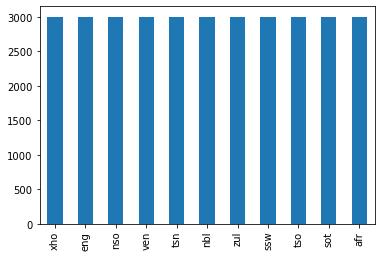

In [969]:
df_train['lang_id'].value_counts().plot(kind= 'bar')
plt.show()

In [970]:
df_train.lang_id.value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

# Data Pre-processing  

1. Removing the Noise 

In [971]:
#removing all links and url's in the test data 
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_test['text'] = df_test['text'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [972]:
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


 2. Removing Punctuation

Train Data

In [973]:
#coverting data to lower case 
df_train['text'] = df_train['text'].str.lower()

In [974]:
#importing the punctuation
import string 
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [975]:
#function to remove punctuation
def remove_punctuation(df_train):
    return ''.join([l for l in df_train if l not in string.punctuation])

In [977]:
#punctuation removed but some still sips in 
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_train['text'].iloc[26858]

'ntle le tataiso ena eo ho nehelanweng ka yona ka hodimo ha ho tshwauwa ditema tsa kgokahano tse telele le tse kgutshwane bahlahlobi ba lekodisise hantle sebopeho ho ya ka mofuta wa tema sebopeho se fapana ho tloha temeng e nngwe ho isa ho e nngwe'

Test Data

In [980]:
#data cleaning for the test data 
df_test['text'] = df_test['text'].str.lower()

In [981]:
import string 
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [982]:
def remove_punctuation(df_test):
    return ''.join([l for l in df_test if l not in string.punctuation])

3. Tokenizer 

Train Data 

In [988]:
#train data broken down into tokens 
tokeniser = TreebankWordTokenizer()
df_train['tokens'] = df_train['text'].apply(tokeniser.tokenize)

In [989]:
#text has been tokenized 
df_train['tokens'].iloc[50]

['prof',
 'frikkie',
 'van',
 'niekerk',
 'mokaedi',
 'wa',
 'setheo',
 'sa',
 'merero',
 'ya',
 'badiri',
 'baithuti',
 'boitshimololedi',
 'le',
 'dipatlisiso',
 'o',
 'ne',
 'a',
 'bolelela',
 'hercevigil',
 'ka',
 'ga',
 'hisetori',
 'ya',
 'yunibesithi',
 'gammogo',
 'le',
 'photefolio',
 'ya',
 'yona',
 'ya',
 'ditshwanelo',
 'tsa',
 'botlhalefi']

Test Data 

In [990]:
#same process as above 
df_test['tokens'] = df_test['text'].apply(tokeniser.tokenize)

In [991]:
df_test['tokens'].iloc[50]

['hodima',
 'moo',
 ',',
 'ditlwaelo',
 'tsa',
 'tshebetso',
 ',',
 'ka',
 'bobedi',
 'ka',
 'ho',
 'ya',
 'ka',
 'ho',
 'ruta',
 'le',
 'ho',
 'ithuta',
 ',',
 'di',
 'bontsha',
 'ho',
 'ba',
 'teng',
 'ho',
 'bakang',
 'matshwenyeho',
 'ha',
 'dikarohano',
 'tsa',
 'setjhaba',
 'tsa',
 'nakong',
 'e',
 'fetileng',
 '.']

3. Stemming the Data 

Train Data 

In [992]:
#loading the stemmer. SA Multilingual languages not available  
stemmer = SnowballStemmer('english')

In [993]:
#defining the stemmer function
def train_stemmer(df_train, stemmer):
    return [stemmer.stem(word) for word in df_train]

Test Data 

In [994]:
#defining the stemmer function
stemma = SnowballStemmer('english')

In [995]:
#producing results of the test data 
def test_stemmer(df_test, stemmer):
    return [stemma.stem(word) for word in df_test]

4. Stop Words 

Train Data 

In [996]:
#limited to English in this data set 
def remove_stop_words_train(df_train):
    return [d for d in df_train if d not in stopwords.words('english')]

Test Data 

In [997]:
#removing the english stop words 
def remove_stop_words_test(df_test):
    return [t for t in df_test if t not in stopwords.words('english')]

5. Bag of Words 

In [998]:
def bag_of_words_count(words, word_dict={}):
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else: 
            word_dict[word] = 1
    return word_dict

In [999]:
type_labels = list(df_train.lang_id.unique())

In [1000]:
lang = {}
for l in type_labels:
    df = df_train.groupby('lang_id')
    lang[l] = {}
    for row in df.get_group(l)['tokens']:
        lang[l] = bag_of_words_count(row, lang[l])

In [1001]:
#Next, we create a list of all of the unique words
all_words = set()
for l in type_labels:
    for word in lang[l]:
        all_words.add(word)

In [1002]:
#This was done so that we can create a combined bag of words dictionary for all the words in the text.

lang['all'] = {}
for l in type_labels:
    for word in all_words:
        if word in lang[l].keys():
            if word in lang['all']:
                lang['all'][word] += lang[l][word]
            else:
                lang['all'][word] = lang[l][word]

In [1003]:
#Now we can easily calculate how many words there are in total.
total_words = sum([v for v in lang['all'].values()])
total_words

1223491

Text(0.5, 0, 'word frequency')

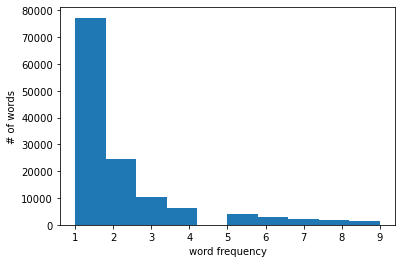

In [1004]:
#Let's take a look at the distribution of words which occur less than 10 times in the whole dataset.
_= plt.hist([v for v in lang['all'].values() if v <10], bins =10)
plt.ylabel("# of words")
plt.xlabel("word frequency")

In [1005]:
#There are a lot of words that only appear once! We'll print out that value here.
len([v for v in lang['all'].values() if v == 1])

77259

In [1006]:
#What kind of words do you think would appear once out of roughly 8 million words? Let's print out a few of these rare words.

rare_words = [k for k, v in lang['all'].items() if v==1]
print(rare_words[:100])

['nezigwebo', 'wayokuthi', 'ngokokulingana', 'kunobulungisa', 'abaphetheyo', 'echatshazelwa', 'ngebhongo', 'usemgangathweni', 'unesinye', 'kukudlala', 'kwentlanganiso', 'kwigazetthi', 'osondela', 'lokusingatha', 'ifikelela', 'iphelisiwe', 'nezazisi', 'baxhomekeka', 'njengomncedisijaji', 'abathathizigqibo', 'ephinde', 'alukwamkeleka', 'okuyidlalileyo', 'liyakuhlomela', 'ingaguqukanga', 'unesidanga', 'ndiyanqanda', 'sivota', 'libekho', 'amangqina', 'zingeloncedo', 'ezilalini', 'kwinkqubosikhokelo', 'kufanelwe', 'nakwizikhokelo', 'ingosuleleka', 'evile', 'zohlolongqondo', 'lambrechts', 'mthathinxaxheba', 'ngotyelelo', 'enokukhetha', 'ukuzigcina', 'aziiarhente', 'kumondli', 'bangakuqeqeshelwanga', 'nkathalelo', 'okungangxamisekanga', 'yayisesokugqibela', 'kwakumqolo', 'ligunyaziswe', 'mdlaio', 'ezinokubona', 'ingaqini', 'kubathuthi', 'kuluxanduva', 'oluhlalisana', 'loorhulumente', 'lukawonkewonke', 'igaba', 'ngokufaneleyo', 'axelele', 'ekude', 'beenqobo', 'yemisintsi', 'ubalaseleyo', 'tume

In [1007]:
# how many words appear more than 10 times?
# how many words of the total does that account for?
print(len([v for v in lang['all'].values() if v >= 10]))
occurs_more_than_10_times = sum([v for v in lang['all'].values() if v >= 10])
print(occurs_more_than_10_times)

13223
959473


In [1008]:
occurs_more_than_10_times/total_words

0.7842092831087437

6. Removing Numbers or Digits 

Train Data 

In [1011]:
df_train['text']=df_train['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

Test Data 

In [1012]:
df_test['text']=df_test['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

The methods used above will insure the model is able to absorb our data, process it and predict the necessary results. 

# Model Building 

Assigning Variables 

In [1013]:
#labels 
y = df_train['lang_id']

#features 
X = df_train['text']

Term Frequency Inverse Document Frequency - TfidfVectorizer - It helps us in dealing with most frequent words that appear in our dataset. 

In [1017]:
vt = TfidfVectorizer(min_df=2, ngram_range=(1,2))
X_transformed = vt.fit_transform(X)

Spliting the Data 

In [1018]:
#splitting our data into test and train 
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.20, random_state = 42)

# Model Selection

There are three models I will be testing for this exam. The K-Nearest Neighbors, Logistic Regression and Multinomial Naive Bayes. I will generate a classification report to show how each model performs. 

1. K-Nearest Neighbors 

In [1019]:
#defining and fitting the regression
Knn_mod = KNeighborsClassifier(n_neighbors=5)
Knn_mod.fit(X_train, y_train)

KNeighborsClassifier()

In [1032]:
#predicting the model and classification report 
knn_pred = Knn_mod.predict(X_test)
print("The accuracy score of the K-Nearest Neighbors is:" , accuracy_score(y_test, knn_pred))
print("\n\nClassification Report:\n\n", metrics.classification_report(y_test, knn_pred))

The accuracy score of the K-Nearest Neighbors is: 0.9757575757575757


Classification Report:

               precision    recall  f1-score   support

         afr       0.99      1.00      1.00       583
         eng       0.99      1.00      0.99       615
         nbl       0.94      0.97      0.95       583
         nso       0.96      0.99      0.97       625
         sot       0.99      0.98      0.98       618
         ssw       0.98      0.97      0.98       584
         tsn       0.98      0.95      0.97       598
         tso       0.99      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.97      0.97      0.97       609
         zul       0.96      0.91      0.93       590

    accuracy                           0.98      6600
   macro avg       0.98      0.98      0.98      6600
weighted avg       0.98      0.98      0.98      6600



2. Logistic Regression 

In [1021]:
#defining and fitting the regression
log_mod = LogisticRegression(n_jobs=1,
                                  C=1e2)
log_mod.fit(X_train, y_train)

LogisticRegression(C=100.0, n_jobs=1)

In [1031]:
#predicting the model and classification report 
log_pred = log_mod.predict(X_test)
print("The accuracy score of the Logistic Regression is:",accuracy_score(y_test, log_pred))
print("\n\nClassification Report:\n\n", metrics.classification_report(y_test,log_pred))

The accuracy score of the Logistic Regression is: 0.9971212121212121


Classification Report:

               precision    recall  f1-score   support

         afr       1.00      0.99      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      1.00      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       0.99      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       0.99      0.99      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



3. Multinomial Naive Bayes 

In [1023]:
parameters = {'alpha': [0.1, 10, 50, 100]} 
Naive_model = (GridSearchCV(MultinomialNB(),
                            param_grid=parameters, 
                                           cv=5,
                                           n_jobs=1,
                                           scoring='f1_weighted'))
Naive_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=1,
             param_grid={'alpha': [0.1, 10, 50, 100]}, scoring='f1_weighted')

In [1030]:
naive_pred = Naive_model.predict(X_test)
print("The accuracy score of the Multinomial Naive Bayes is:",accuracy_score(y_test, naive_pred))
print("\n\nClassification Report:\n\n", metrics.classification_report(y_test,naive_pred))

The accuracy score of the Multinomial Naive Bayes is: 0.9992424242424243


Classification Report:

               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       1.00      1.00      1.00       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       1.00      1.00      1.00       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



# Model Perfomance

The Accuracy ccores below: 

    K-Nearest Neighbors Model          97.57%
    
    Logistic Regression                99.71%
    
    Multinomial Naive Bayes            99.92%

As per the above accuracy scores, it is evident that the Multinomial Naive Bayes produced the most valid predictions even though the other models are behind by a few margins. It was able to identify the language from the text and assign it correctly. The K-Nearest Neighbors was the lowest perfoming models in predictions. 

# Model Evaluation 

In [1033]:
# transforming the testing data using vectorizer
fin_test = df_test['text']
fin_test_vt = vt.transform(fin_test)

In [1034]:
#assigning the transformed test data to the predictions knn model 
knn_pred = Knn_mod.predict(fin_test_vt)

In [1035]:
#assigning the transformed test data to the predictions logistic regression model
log_pred = log_mod.predict(fin_test_vt)

In [1036]:
#assigning the transformed test data to the predictions logistic regression model
naive_pred = Naive_model.predict(fin_test_vt)

We can update the model predictions below: 

In [1037]:
df_test['lang_id'] = naive_pred
df_test.head()

,index,text,tokens,lang_id
0,1,"mmasepala, fa maemo a a kgethegileng a letlele...","[mmasepala, ,, fa, maemo, a, a, kgethegileng, ...",tsn
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...,"[uzakwaziswa, ngokufaneleko, nakungafuneka, em...",nbl
2,3,tshivhumbeo tshi fana na ngano dza vhathu.,"[tshivhumbeo, tshi, fana, na, ngano, dza, vhat...",ven
3,4,kube inja nelikati betingevakala kutsi titsini...,"[kube, inja, nelikati, betingevakala, kutsi, t...",ssw
4,5,winste op buitelandse valuta.,"[winste, op, buitelandse, valuta, .]",afr


Submission Overview 

In [1038]:
df_submission = df_test[['index','lang_id']]
df_submission.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


# Model Submission 

In [1042]:
df_submission.to_csv('model_knn.csv', index=False)

In [1045]:
df_submission.to_csv('model_log_regress.csv', index=False)

In [1046]:
df_submission.to_csv('model_naive.csv', index=False)

# References 

How to Understand Machine Learning - Explore Academy 